In [1]:
%matplotlib inline
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import json
import cv2
import glob
os.environ["OPENCV_LOG_LEVEL"]="SILENT"



In [2]:
#from brailsmodule import ImageCapture, RoofShapeLLM, VLMImageClassifer
# from brails.modules import VLMClassifier, VLMSegmenter
# from brails.InventoryGenerator import InventoryGenerator

## Inventory Processing

In [2]:
import os
import sys
from brails import Importer

# sys.path.insert(1, "../../")

# This script needs a Google API Key to run.
# We suggest placing your API key in file apiKey.txt in the same directory as 
# this script if you plan to commit changes to this example. This way, you do 
# not risk accidentally uploading your API key (apiKey.txt is in .gitignore, 
# so you have work to do to get it uploaded)

apiKey = ""
if os.path.exists("apiKey.txt"):
    with open("apiKey.txt", "r") as file:
        apiKey = file.readline().strip()  # Read the first line and strip whitespace

# Create the importer:
importer = Importer()

# Select a region and create its RegionBoundary:
region_data = {"type": "locationName", "data": "Tiburon, CA"}
region_boundary_class = importer.get_class("RegionBoundary")
region_boundary_object = region_boundary_class(region_data)

# Get AssetInventory for buildings in the defined region via 
# USA_FootprintScraper:
print("Running USA_FootprintsScraper...")

usa_class = importer.get_class("USA_FootprintScraper")
usa_data = {"length": "ft"}
instance2 = usa_class(usa_data)
usa_inventory = instance2.get_footprints(region_boundary_object)

print("\nTotal number of assets detected using FEMA USA Structures data: "
      , len(usa_inventory.inventory))

# Subsample from the extracted assets to keep the image downloading step quick.
# Here, we are randomly sampling 15 buildings using a random seed value of 40:
small_inventory = usa_inventory.get_random_sample(15, 40)
print("Number of assets in the selected subset: ", 
      len(small_inventory.inventory))
 
# Get aerial imagery for the selected subset using GoogleSatellite:
google_satellite_class = importer.get_class("GoogleSatellite")
google_satellite = google_satellite_class()
images_satellite = google_satellite.get_images(small_inventory, "tmp/satellite/")

images_satellite.print()

# Get street level imagery for the selected subset using GoogleStreetview:
google_street_class = importer.get_class("GoogleStreetview")
google_input = {"apiKey": apiKey}
google_street = google_street_class(google_input)
images_street = google_street.get_images(small_inventory, "tmp/street/")
images_street.print()

Running USA_FootprintsScraper...

Searching for Tiburon, CA...
Found Tiburon, Marin County, California, 94920, United States

Meshing the defined area...


Obtaining the number of buildings in each cell: 100%|█| 7/7 [00:00<00:00, 21.98i



Meshing complete. Split Tiburon into 6 cells


Obtaining the building attributes for each cell: 100%|█| 6/6 [00:00<00:00,  6.54
100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 88301.14it/s]



Found a total of 3574 building footprints in Tiburon

Total number of assets detected using FEMA USA Structures data:  3574
Number of assets in the selected subset:  15


Obtaining satellite imagery: 100%|██████████████| 15/15 [00:00<00:00, 16.77it/s]



ImageSet : NAME WOULD BE NICE
directory: tmp/satellite
images (num images:  15 )

key:  1878 filename:  imsat_37.89768351-122.49820422.jpg
key:  2373 filename:  imsat_37.88906007-122.46303168.jpg
key:  2146 filename:  imsat_37.90276104-122.48159414.jpg
key:  130 filename:  imsat_37.88453485-122.46962792.jpg
key:  1004 filename:  imsat_37.87676895-122.44555421.jpg
key:  1156 filename:  imsat_37.90385994-122.4769534.jpg
key:  2722 filename:  imsat_37.90305823-122.48872001.jpg
key:  2609 filename:  imsat_37.90002487-122.49900745.jpg
key:  2721 filename:  imsat_37.90299175-122.47287374.jpg
key:  845 filename:  imsat_37.87970349-122.44914681.jpg
key:  525 filename:  imsat_37.8801675-122.45402246.jpg
key:  3121 filename:  imsat_37.90402784-122.50001359.jpg
key:  1427 filename:  imsat_37.898544-122.4930143.jpg
key:  1135 filename:  imsat_37.89606647-122.48558995.jpg
key:  3044 filename:  imsat_37.89082771-122.46583307.jpg




Obtaining street-level imagery: 100%|███████████| 15/15 [00:05<00:00,  2.74it/s]


ImageSet : NAME WOULD BE NICE
directory: tmp/street
images (num images:  14 )

key:  1878 filename:  gstrt_1878.jpg  properties:  {'elev': 8.510666847229004, 'latlon': (37.89758010528647, -122.4982789128197), 'depthmap': 'dmstreet_37.89768351-122.49820422.txt', 'fov': 0.5826901197433472, 'heading': 296.5553894042969, 'pitch': 90.13355255126953, 'zoom_level': 3}
key:  2373 filename:  gstrt_2373.jpg  properties:  {'elev': 138.8587341308594, 'latlon': (37.88868837714572, -122.463425563316), 'depthmap': 'dmstreet_37.88906007-122.46303168.txt', 'fov': 359.4360046386719, 'heading': 297.0581359863281, 'pitch': 95.65435028076172, 'zoom_level': 3}
key:  2146 filename:  gstrt_2146.jpg  properties:  {'elev': 56.22102737426758, 'latlon': (37.90283996380768, -122.4817041225061), 'depthmap': 'dmstreet_37.90276104-122.48159414.txt', 'fov': 358.78515625, 'heading': 76.30313110351562, 'pitch': 88.92350006103516, 'zoom_level': 3}
key:  130 filename:  gstrt_130.jpg  properties:  {'elev': 44.888572692871

In [4]:
'''
Purpose: Predict buillding attributes
'''

# import sys
# import importlib.util

#if importlib.util.find_spec("brails") is None:
# sys.path.insert(1,'../../')

print('ROOF_SHAPE_VLM PREDICTIONS')
my_class = importer.get_class('RoofShapeVLM')
my_classifier = my_class()
predictions = my_classifier.predict(images_satellite)
print(predictions)

# print('NFLOORS_VLM PREDICTIONS')
# my_class = importer.get_class('NFloorVLM')
# my_classifier = my_class()
# predictions = my_classifier.predict(images_street) 
# print(predictions)


ROOF_SHAPE_VLM PREDICTIONS
{1878: 'Flat', 2373: 'Flat', 2146: 'Flat', 130: 'Flat', 1004: 'Flat', 1156: 'Flat', 2722: 'Flat', 2609: 'Flat', 2721: 'Flat', 845: 'Flat', 525: 'Flat', 3121: 'Flat', 1427: 'Flat', 1135: 'Flat', 3044: 'Flat'}


<Figure size 640x480 with 0 Axes>

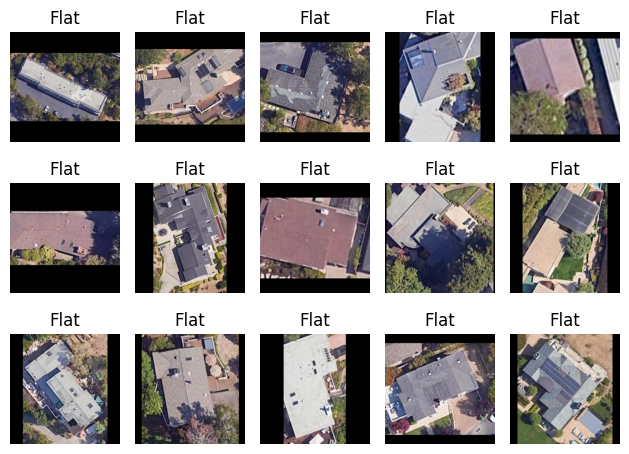

In [5]:
# RoofShape Classification
%matplotlib inline
plt.figure()
curr_dir = "tmp/satellite/"

for idx, (key, img) in enumerate(images_satellite.images.items()):
    filename = img.filename
    img_path = os.path.join(curr_dir, filename)
    img = mpimg.imread(img_path)    
    pred = predictions[key]
    plt.subplot(3, 5, idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(pred)
    plt.axis('off')
plt.tight_layout()
plt.margins(0,0)
plt.show()